<a href="https://colab.research.google.com/github/paliwalpiyush151/Covid19_Forecasting_using_AI/blob/main/code_Time_Series_Forecasting_with_Parametric_Curve_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tf-utils

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from tf_utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dtf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,37596,37599,37599,37599,37856,37894,37953,37999,38054,38070,38113,38129,38140,38143,38162,38165,38196,38243,38288,38304,38324,38398,38494,38520,38544,38572,38606,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074,39096,39145,39170
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7380,7499,7654,7812,7967,8119,8275,8427,8605,8759,8927,9083,9195,9279,9380,9513,9606,9728,9844,9967,10102,10255,10406,10553,10704,10860,11021,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535,12666,12787,12921
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,38583,39025,39444,39847,40258,40667,41068,41460,41858,42228,42619,43016,43403,43781,44146,44494,44833,45158,45469,45773,46071,46364,46653,46938,47216,47488,47752,48007,48254,48496,48734,48966,49194,49413,49623,49826,50023,50214,50400,50579
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,989,1005,1005,1024,1024,1045,1045,1045,1060,1060,1098,1098,1124,1124,1124,1176,1184,1199,1199,1215,1215,1215,1261,1261,1301,1301,1344,1344,1344,1438,1438,1483,1483,1564,1564,1564,1681,1681,1753,1753
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1906,1935,1966,2015,2044,2068,2134,2171,2222,2283,2332,2415,2471,2551,2624,2654,2729,2777,2805,2876,2935,2965,2981,3033,3092,3217,3279,3335,3388,3439,3569,3675,3789,3848,3901,3991,4117,4236,4363,4475


# Curve fitting for **India**

In [ ]:

## groupby country
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["India"].values, columns=["total"])

## create daily changes column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')


In [ ]:
dtf.tail(10)

,total,new
2020-09-15,5020359,90123.0
2020-09-16,5118253,97894.0
2020-09-17,5214677,96424.0
2020-09-18,5308014,93337.0
2020-09-19,5400619,92605.0
2020-09-20,5487580,86961.0
2020-09-21,5562663,75083.0
2020-09-22,5562663,0.0
2020-09-23,5646010,83347.0
2020-09-24,5732518,86508.0


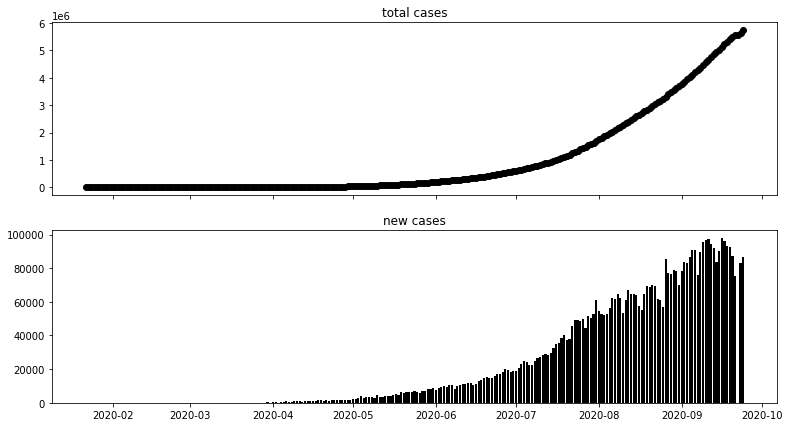

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,7))
ax[0].scatter(dtf.index, dtf["total"].values, color="black")
ax[0].set(title="total cases")
ax[1].bar(dtf.index, dtf["new"].values, color="black")
ax[1].set(title="new cases")
plt.show()

In [ ]:

'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 2500*x

y_linear = f(x=np.arange(len(dtf)))

In [ ]:
'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 10 + 1.091**x

y_exponential = f(x=np.arange(len(dtf)))

In [ ]:
'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 350000 / (1 + np.exp(-0.5*(x-20)))

y_logistic = f(x=np.arange(len(dtf)))

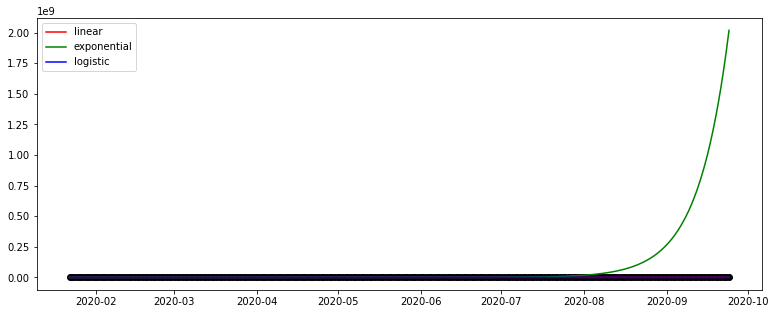

In [ ]:
fig, ax = plt.subplots(figsize=(13,5))
ax.scatter(dtf["total"].index, dtf["total"].values, color="black")
ax.plot(dtf["total"].index, y_linear, label="linear", color="red")
ax.plot(dtf["total"].index, y_exponential, label="exponential", color="green")
ax.plot(dtf["total"].index, y_logistic, label="logistic", color="blue")
ax.legend()
plt.show()

#-> Data starts low and grows exponentially ... looks similar to a exponential function. But I know for fact that
#   this phenomenon has an upper limit, because the virus can't infect more than the total population of the country.
#   Therefore the logistic function is more appropriate to model this data.

In [ ]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(x):
    return 12000 * np.exp(-0.5 * ((x-145)/21)**2)

y_gaussian = f(x=np.arange(len(dtf)))

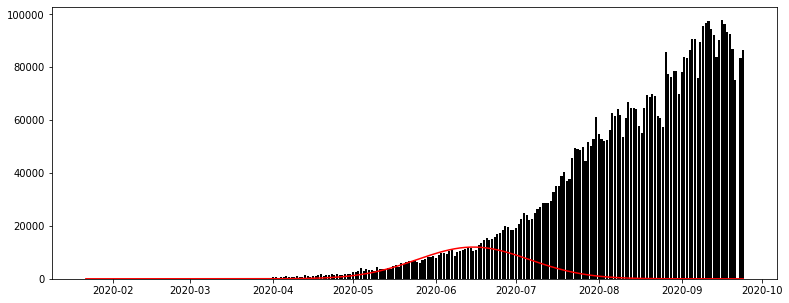

In [ ]:
fig, ax = plt.subplots(figsize=(13,5))
ax.bar(dtf["new"].index, dtf["new"].values, color="black")
ax.plot(dtf["new"].index, y_gaussian, color="red")
plt.show()

In [ ]:
from scipy.optimize import curve_fit
'''
Logistic function: f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def logistic_f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y
## optimize from scipy
X=np.arange(len(dtf["total"]))
y=dtf["total"].values
logistic_model, cov = curve_fit(logistic_f,
                                X, 
                               y , 
                                maxfev=10000,
                                p0=[np.max(dtf["total"]), 1, 1])
## print the parameters
logistic_model

array([8.96228840e+06, 3.74585919e-02, 2.30725176e+02])

In [ ]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def gaussian_f(X, a, b, c):
    y_prime = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y_prime
## optimize from scipy
X1=np.arange(len(dtf["new"]))
y1=dtf["new"].values
gaussian_model, cov = curve_fit(gaussian_f,
                                X1, 
                                y1, 
                                maxfev=10000,
                                p0=[1,np.mean(dtf["new"]),1])
## print the parameters
gaussian_model

array([1.00000000e+00, 2.32085749e+04, 1.00000000e+00])

In [ ]:
'''
Plot parametric fitting fuction.
'''
def utils_plot_parametric(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dtf["model"].plot(ax=ax[0], color="green")
    dtf["forecast"].plot(ax=ax[0], grid=True, color="red")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)
   
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:]["ts"].plot(marker=".", linestyle='None', ax=ax[1], color="black", 
                                  title="Zoom on the last "+str(zoom)+" observations")
    dtf.loc[zoom_idx:]["model"].plot(ax=ax[1], color="green")
    dtf.loc[zoom_idx:]["forecast"].plot(ax=ax[1], grid=True, color="red")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    plt.show()
    
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [ ]:
'''
Forecast unknown future.
:parameter
    :param ts: pandas series
    :param f: function
    :param model: list of optim params
    :param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
    :param freq: None or str - 'B' business day, 'D' daily, 'W' weekly, 'M' monthly, 'A' annual, 'Q' quarterly
    :param zoom: for plotting
'''
def forecast_curve(ts, f, model, pred_ahead=None, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    ## index
    index = pd.date_range(start='2020-09-23',periods=pred_ahead,freq=freq)
    index = index[1:]
    ## forecast
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf

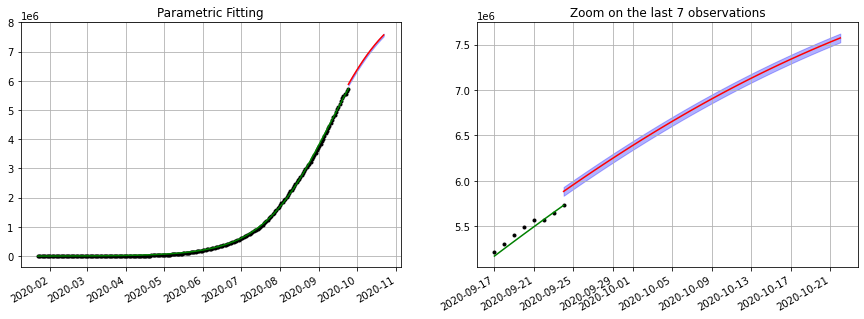

In [ ]:
preds = forecast_curve(dtf["total"], logistic_f, logistic_model, 
                       pred_ahead=30, freq="D", zoom=7)

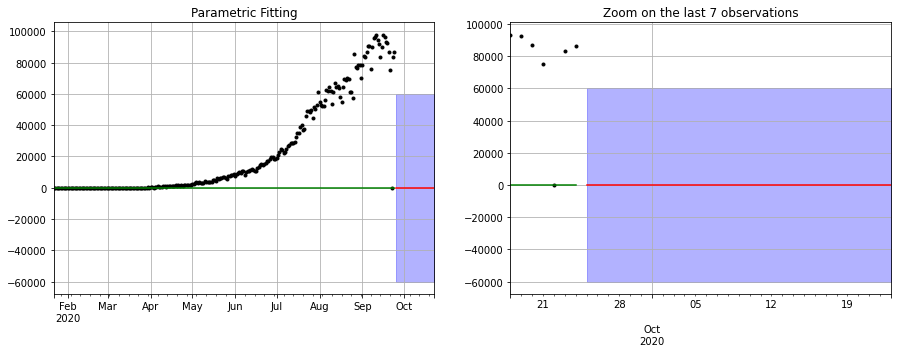

In [ ]:
## Forecast
preds = forecast_curve(dtf["new"], gaussian_f, gaussian_model, pred_ahead=30,freq="D", zoom=7, figsize=(15,5))

For some reason we are not getting good fit with gaussian function, I guess it's just the matter of parameter scaling.

Trying with lmfit, if we can get the results.

In [ ]:
!pip install lmfit

     |████████████████████████████████| 266kB 7.3MB/s 
     |████████████████████████████████| 215kB 13.4MB/s 
     |████████████████████████████████| 256kB 18.7MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81991 sha256=7cd287f5943420e36fc63f6b95756cfcd6e330c6fbaa2b6f2468c2b7fdbf219e
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.19-cp36-none-any.whl size=17486 sha256=c766dc63e86257b692c55bbbe1441d816c017f28c808a5713720cc86e730b25f
  Stored in directory: /root/.cache/pip/wheels/59/da/bf/62853db4291f1c5f91326e32e4d1766b8cfcccd1c0e6eaf53f
Successfully built lmfit asteval


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 247
    # variables        = 3
    chi-square         = 3.6322e+11
    reduced chi-square = 1.4886e+09
    Akaike info crit   = 5219.89192
    Bayesian info crit = 5230.42008
##  Warning: uncertainties could not be estimated:
    amp:  at initial value
    cen:  at initial value
    wid:  at initial value
[[Variables]]
    amp:  1.00000000 (init = 1)
    cen:  23208.5749 (init = 23208.57)
    wid:  1.00000000 (init = 1)


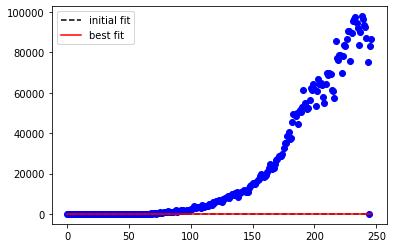

In [ ]:
from lmfit import Model
import math
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (math.sqrt(2*math.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))


gmodel = Model(gaussian)
result = gmodel.fit(y1, x=X1, amp=1, cen=np.mean(dtf["new"]), wid=1)

print(result.fit_report())

plt.plot(X1, y1, 'bo')
plt.plot(X1, result.init_fit, 'k--', label='initial fit')
plt.plot(X1, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()
# <end examples/doc_model_gaussian.py>

This happening because, data has not taken gaussian shape yet,so curve_fit as well lmfit may not be able to fit properly.